In [30]:
#!pip install mtcnn

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import PIL
import os
from tqdm import tqdm
import gc
import copy 
from mtcnn import MTCNN

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
detector = MTCNN()

In [33]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [34]:
frames_per_video = 16
device = ("cuda" if torch.cuda.is_available() else "cpu")

file_path = "/kaggle/input/FF++"

# Dataset

In [35]:
class VideoDataset(Dataset):
    
    def __init__(self, video_paths, labels, transform=None, frames_per_video=frames_per_video, cache_dir="./cache_dir"):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.frames_per_video=frames_per_video
        self.cache_dir = cache_dir

        os.makedirs(self.cache_dir, exist_ok = True)

      
    def extract_frames(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            return [np.zeros((224, 224, 3), dtype=np.uint8)] * self.frames_per_video
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        frame_indices = np.linspace(0, total_frames-1, self.frames_per_video, dtype=int)
        
        for idx in frame_indices:
            
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if not ret:
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                ret, frame = cap.read()
                
                if not ret:
                    frame = np.zeros((224, 224, 3), dtype=np.uint8)
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            detections = detector.detect_faces(frame)

            if len(detections) > 0:
                x, y, w, h = detections[0]['box']
                x, y = max(0, x), max(0, y)
                face = frame[y:y+h, x:x+w]
                frame = cv2.resize(face, (224, 224))
            
            else:
                frame = cv2.resize(frame, (224, 224))
            
            frames.append(frame)
        
        cap.release()
        
        while len(frames) < self.frames_per_video:
            frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))
        
        return frames[:self.frames_per_video]
                
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        cache_file = os.path.join(self.cache_dir, f"{os.path.basename(video_path)}.pt")

        if os.path.exists(cache_file):
            frames_tensor = torch.load(cache_file)
            
        else:
            frames = self.extract_frames(video_path)
                
            if self.transform:
                frames = [self.transform(frame) for frame in frames]

            else:
                frames = [torch.tensor(frame).permute(2,0,1).float() / 255.0 for frame in frames]

            frames_tensor = torch.stack(frames)
            torch.save(frames_tensor, cache_file)

        return (frames_tensor, torch.tensor(label, dtype=torch.long))
    

    def __len__(self):
        return len(self.video_paths)

In [36]:
def load_dataset(data_path):
    
    real_path = os.path.join(data_path, "real")
    fake_path = os.path.join(data_path, "fake")

    video_paths = []
    labels = []

    if os.path.exists(real_path):
        real_videos = [f for f in os.listdir(real_path)]

        for video in real_videos:
            video_paths.append(os.path.join(real_path, video))
            labels.append(0)  # real

    if os.path.exists(fake_path):
        fake_videos = [f for f in os.listdir(fake_path)]

        for video in fake_videos:
            video_paths.append(os.path.join(fake_path, video))
            labels.append(1)  # fake

    return video_paths, labels

In [37]:
video_paths, labels = load_dataset(file_path)

print(len(video_paths))
print(len(labels))
print(list(set(labels)))
print(video_paths[:6])

400
400
[0, 1]
['/kaggle/input/FF++/real/08__talking_against_wall.mp4', '/kaggle/input/FF++/real/14__walking_down_indoor_hall_disgust.mp4', '/kaggle/input/FF++/real/08__walking_down_street_outside_angry.mp4', '/kaggle/input/FF++/real/05__outside_talking_still_laughing.mp4', '/kaggle/input/FF++/real/14__exit_phone_room.mp4', '/kaggle/input/FF++/real/06__walk_down_hall_angry.mp4']


In [38]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [39]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(video_paths, labels, train_size=0.7, 
                                                              random_state=42, stratify=labels, shuffle=True)

val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, train_size=0.7, 
                                                                  random_state=42, stratify=temp_labels, shuffle=True)

In [40]:
from collections import Counter

print(Counter(train_labels))
print(Counter(val_labels))
print(Counter(test_labels))

Counter({1: 140, 0: 140})
Counter({0: 42, 1: 42})
Counter({0: 18, 1: 18})


In [41]:
cache_dir = "/kaggle/working/cache_dir"

In [42]:
train_dataset = VideoDataset(video_paths=train_paths, labels=train_labels, transform=train_transform, frames_per_video=frames_per_video, cache_dir=cache_dir)
val_dataset = VideoDataset(video_paths=val_paths, labels=val_labels, transform=val_transform, frames_per_video=frames_per_video, cache_dir=cache_dir)
test_dataset = VideoDataset(video_paths=test_paths, labels=test_labels, transform=val_transform, frames_per_video=frames_per_video, cache_dir=cache_dir)

In [43]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [44]:
'''
for batch_idx, (videos, labels) in enumerate(test_loader):
    print("Videos shape:", videos.shape)
    print("Labels shape:", labels.shape)
    break
'''

'\nfor batch_idx, (videos, labels) in enumerate(test_loader):\n    print("Videos shape:", videos.shape)\n    print("Labels shape:", labels.shape)\n    break\n'

# Helper Functions

In [45]:
def train_model_one_epoch(model, train_loader, optimizer, loss_fn, device, scheduler=None):

    total_train_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
        
    model.train()
    train_tqdm = tqdm(train_loader, desc="Training: ")

    for batch_idx, (frames, labels) in enumerate(train_tqdm):
        
        frames, labels = frames.to(device), labels.to(device)

        optimizer.zero_grad()
        
        output = model(frames)       
        loss = loss_fn(output, labels)
        
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        probs = torch.softmax(output, dim=1)[:,1]

        all_preds.extend(predicted.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        
        train_tqdm.set_postfix({"Loss": f"{loss.item():.4f}"})

    
    train_loss = total_train_loss / len(train_loader)

    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average="binary")
    train_recall = recall_score(all_labels, all_preds, average="binary")
    train_f1 = f1_score(all_labels, all_preds, average="binary")    
    

    return (
        train_loss,
        train_accuracy,
        train_precision,
        train_recall,
        train_f1,
        all_probs
    )

In [46]:
def val_model_one_epoch(model, val_loader, loss_fn, device):
    
    total_val_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    best_model_state = None
    model.eval()

    with torch.no_grad():
            
        val_tqdm = tqdm(val_loader, desc="Validation: ")
        
        for frames, labels in val_tqdm:
            
            frames, labels = frames.to(device), labels.to(device)
      
            output = model(frames)
            loss = loss_fn(output, labels)
    
            total_val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            probs = torch.softmax(output, dim=1)[:,1]
                    
            all_preds.extend(predicted.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

            val_tqdm.set_postfix(loss=loss.item())

    
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, average="binary")
    val_recall = recall_score(all_labels, all_preds, average="binary")
    val_f1 = f1_score(all_labels, all_preds, average="binary")
    val_loss = total_val_loss / len(val_loader)

    print(classification_report(all_labels, all_preds))

    return (
        val_loss,
        val_accuracy,
        val_precision,
        val_recall,
        val_f1,
        all_probs
    )

# Modeling

## 1. XceptionNet + LSTM

In [47]:
import timm  

xception_base = timm.create_model("xception", pretrained=True)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [48]:
class XceptionLSTM(nn.Module):
    def __init__(self, xception_model, hidden_size=256, num_layers=1, num_classes=2):
        super().__init__()
        xception_model.reset_classifier(0)
        self.xception_features = xception_model
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        B, T, C, H, W = x.shape

        # Merge batch and frames
        x = x.view(B*T, C, H, W)
        features = self.xception_features(x)  # (B*T, 2048)
        features = features.view(B, T, -1)    # (B, T, 2048)

        lstm_out, _ = self.lstm(features)     # (B, T, hidden_size)
        out = self.fc(self.dropout(lstm_out[:, -1, :]))  # last timestep
        return out

### Hyperparameters

In [49]:
model = XceptionLSTM(xception_base, hidden_size=256, num_layers=1, num_classes=2)
model = model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr = 0.001,
    weight_decay = 0.01
)

scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0 = 8,
    T_mult = 2,
    eta_min = 1e-6
)

loss_fn = nn.CrossEntropyLoss()

epochs = 20

In [50]:
best_val_f1 = 0
best_val_loss = float("inf")
patience = 4
counter = 0

In [51]:
print(next(model.parameters()).device)
print(device)

cuda:0
cuda


In [52]:
print(len(video_paths))
print(len(labels))
print(list(set(labels)))
print(video_paths[:6])
print(labels[:15])

400
400
[0, 1]
['/kaggle/input/FF++/real/08__talking_against_wall.mp4', '/kaggle/input/FF++/real/14__walking_down_indoor_hall_disgust.mp4', '/kaggle/input/FF++/real/08__walking_down_street_outside_angry.mp4', '/kaggle/input/FF++/real/05__outside_talking_still_laughing.mp4', '/kaggle/input/FF++/real/14__exit_phone_room.mp4', '/kaggle/input/FF++/real/06__walk_down_hall_angry.mp4']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [53]:
for epoch in range(epochs):
    
    print(f"\nEpoch: {epoch+1}/{epochs}")

    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_probs = train_model_one_epoch(model = model, 
                        train_loader = train_loader, optimizer = optimizer, loss_fn = loss_fn, device=device)

    val_loss, val_accuracy, val_precision,val_recall, val_f1, val_probs = val_model_one_epoch(model = model, 
                        val_loader = val_loader, loss_fn = loss_fn, device=device)

    scheduler.step()

    print(f"\nTRAINING METRICS: ")
    print(f"Loss: {train_loss}  Accuracy: {train_accuracy}  Precision: {train_precision}  Recall: {train_recall}  F1 Score: {train_f1}")

    torch.cuda.empty_cache()
    gc.collect()

    print(f"\nValiation METRICS: ")
    print(f"Loss: {val_loss}  Accuracy: {val_accuracy}  Precision: {val_precision}  Recall: {val_recall}  F1 Score: {val_f1}")

    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = copy.deepcopy(model.state_dict())
        print("Best Model Updated")


    if best_val_loss > val_loss:
        best_val_loss = val_loss
        counter = 0

    else:
        counter += 1

    if counter >= patience:
        print("Early Stopping Triggered")
        break


Epoch: 1/20


Validation: 100%|██████████| 21/21 [42:55<00:00, 122.62s/it, loss=0.67] 


              precision    recall  f1-score   support

           0       0.53      0.98      0.69        42
           1       0.86      0.14      0.24        42

    accuracy                           0.56        84
   macro avg       0.69      0.56      0.47        84
weighted avg       0.69      0.56      0.47        84


TRAINING METRICS: 
Loss: 0.7029574939182827  Accuracy: 0.45357142857142857  Precision: 0.46153846153846156  Recall: 0.5571428571428572  F1 Score: 0.5048543689320389

Valiation METRICS: 
Loss: 0.684630498999641  Accuracy: 0.5595238095238095  Precision: 0.8571428571428571  Recall: 0.14285714285714285  F1 Score: 0.24489795918367344
Best Model Updated

Epoch: 2/20


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.69it/s, loss=0.66] 


              precision    recall  f1-score   support

           0       0.78      0.83      0.80        42
           1       0.82      0.76      0.79        42

    accuracy                           0.80        84
   macro avg       0.80      0.80      0.80        84
weighted avg       0.80      0.80      0.80        84


TRAINING METRICS: 
Loss: 0.6501693057162421  Accuracy: 0.6392857142857142  Precision: 0.672566371681416  Recall: 0.5428571428571428  F1 Score: 0.6007905138339921

Valiation METRICS: 
Loss: 0.5952314989907401  Accuracy: 0.7976190476190477  Precision: 0.8205128205128205  Recall: 0.7619047619047619  F1 Score: 0.7901234567901233
Best Model Updated

Epoch: 3/20


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s, loss=0.975]


              precision    recall  f1-score   support

           0       0.64      0.83      0.72        42
           1       0.76      0.52      0.62        42

    accuracy                           0.68        84
   macro avg       0.70      0.68      0.67        84
weighted avg       0.70      0.68      0.67        84


TRAINING METRICS: 
Loss: 0.6386381668703897  Accuracy: 0.6392857142857142  Precision: 0.6308724832214765  Recall: 0.6714285714285714  F1 Score: 0.6505190311418685

Valiation METRICS: 
Loss: 0.60472395945163  Accuracy: 0.6785714285714286  Precision: 0.7586206896551724  Recall: 0.5238095238095238  F1 Score: 0.6197183098591549

Epoch: 4/20


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s, loss=0.448]


              precision    recall  f1-score   support

           0       0.79      0.81      0.80        42
           1       0.80      0.79      0.80        42

    accuracy                           0.80        84
   macro avg       0.80      0.80      0.80        84
weighted avg       0.80      0.80      0.80        84


TRAINING METRICS: 
Loss: 0.5897450119256973  Accuracy: 0.7178571428571429  Precision: 0.6894409937888198  Recall: 0.7928571428571428  F1 Score: 0.7375415282392026

Valiation METRICS: 
Loss: 0.5190141704820451  Accuracy: 0.7976190476190477  Precision: 0.8048780487804879  Recall: 0.7857142857142857  F1 Score: 0.7951807228915663
Best Model Updated

Epoch: 5/20


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s, loss=0.365]


              precision    recall  f1-score   support

           0       0.68      0.67      0.67        42
           1       0.67      0.69      0.68        42

    accuracy                           0.68        84
   macro avg       0.68      0.68      0.68        84
weighted avg       0.68      0.68      0.68        84


TRAINING METRICS: 
Loss: 0.642548765880721  Accuracy: 0.6035714285714285  Precision: 0.6074074074074074  Recall: 0.5857142857142857  F1 Score: 0.5963636363636364

Valiation METRICS: 
Loss: 0.6082521464143481  Accuracy: 0.6785714285714286  Precision: 0.6744186046511628  Recall: 0.6904761904761905  F1 Score: 0.6823529411764705

Epoch: 6/20


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s, loss=0.857]


              precision    recall  f1-score   support

           0       0.79      0.64      0.71        42
           1       0.70      0.83      0.76        42

    accuracy                           0.74        84
   macro avg       0.75      0.74      0.74        84
weighted avg       0.75      0.74      0.74        84


TRAINING METRICS: 
Loss: 0.5751832308513778  Accuracy: 0.6928571428571428  Precision: 0.6607142857142857  Recall: 0.7928571428571428  F1 Score: 0.7207792207792209

Valiation METRICS: 
Loss: 0.5630856865928286  Accuracy: 0.7380952380952381  Precision: 0.7  Recall: 0.8333333333333334  F1 Score: 0.7608695652173915

Epoch: 7/20


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s, loss=0.671]


              precision    recall  f1-score   support

           0       0.89      0.57      0.70        42
           1       0.68      0.93      0.79        42

    accuracy                           0.75        84
   macro avg       0.79      0.75      0.74        84
weighted avg       0.79      0.75      0.74        84


TRAINING METRICS: 
Loss: 0.5098863033311708  Accuracy: 0.7714285714285715  Precision: 0.7567567567567568  Recall: 0.8  F1 Score: 0.7777777777777778

Valiation METRICS: 
Loss: 0.6149296774750664  Accuracy: 0.75  Precision: 0.6842105263157895  Recall: 0.9285714285714286  F1 Score: 0.7878787878787878

Epoch: 8/20


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s, loss=0.529]


              precision    recall  f1-score   support

           0       0.74      0.76      0.75        42
           1       0.76      0.74      0.75        42

    accuracy                           0.75        84
   macro avg       0.75      0.75      0.75        84
weighted avg       0.75      0.75      0.75        84


TRAINING METRICS: 
Loss: 0.45239066779613496  Accuracy: 0.8142857142857143  Precision: 0.8188405797101449  Recall: 0.8071428571428572  F1 Score: 0.8129496402877698

Valiation METRICS: 
Loss: 0.5533896280186517  Accuracy: 0.75  Precision: 0.7560975609756098  Recall: 0.7380952380952381  F1 Score: 0.746987951807229
Early Stopping Triggered


In [54]:
if best_model_state:
    model.load_state_dict(best_model_state)

In [55]:
model_path = "/kaggle/working/deepfake_trial.pth"

torch.save(model.state_dict(), model_path)

### Test Set

In [56]:
test_loss, test_accuracy, test_precision,test_recall, test_f1, test_probs = val_model_one_epoch(model = model, 
                        val_loader = test_loader, loss_fn = loss_fn, device=device)

Validation: 100%|██████████| 9/9 [18:41<00:00, 124.63s/it, loss=0.4]  

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.83      0.83      0.83        18

    accuracy                           0.83        36
   macro avg       0.83      0.83      0.83        36
weighted avg       0.83      0.83      0.83        36



In [57]:
print(roc_auc_score(train_labels, train_probs))
print(roc_auc_score(val_labels, val_probs))
print(roc_auc_score(test_labels, test_probs))

0.44673469387755105
0.7998866213151927
0.8703703703703703


In [59]:
print(test_loss, test_accuracy, test_precision,test_recall, test_f1)

0.5125870472855039 0.8333333333333334 0.8333333333333334 0.8333333333333334 0.8333333333333334


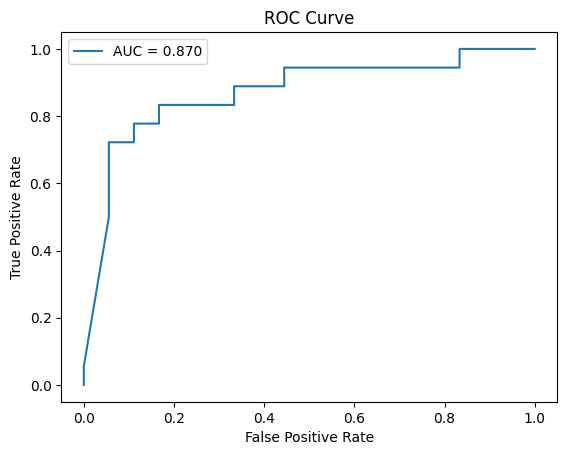

In [61]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
import seaborn as sns

# ROC
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

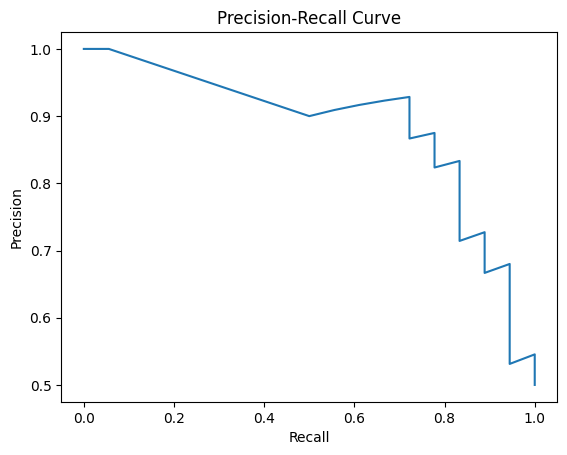

In [62]:
precision, recall, _ = precision_recall_curve(test_labels, test_probs)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

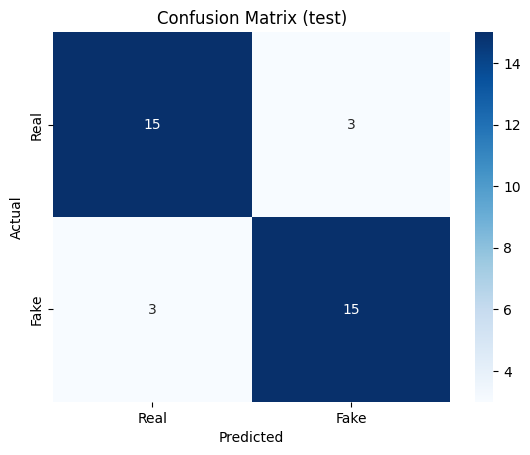

In [64]:
probs_arr = np.array(test_probs)

preds = (probs_arr > 0.5).astype(int)

cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix (test)")
plt.show()